In [1]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
%matplotlib inline

# Dissipative Jaynes-Cummings Model

<img src="diss_jc_model.png",width=400>
<br>
$$
\begin{equation}
H = \hbar\omega_{c}a^{\dagger}a + \frac{1}{2}\hbar\omega_{a}\sigma_{-}^{\dagger}\sigma_{-}+\hbar g(a^{\dagger}\sigma_{-}+a\sigma_{-}^{\dagger})
\end{equation}
$$

Build up the Hamiltonian same as before:

In [2]:
N = 15                 # number of cavity fock states
wc = 1.0  * 2 * np.pi  # cavity frequency
wa = 1.0  * 2 * np.pi  # atom frequency
g  = 0.05 * 2 * np.pi  # coupling strength

# operators
a  = qt.tensor(qt.destroy(N), qt.qeye(2)) # qeye is short for identity
sm = qt.tensor(qt.qeye(N), qt.sigmam())

# Hamiltonian
H = wc * a.dag() * a + wa * sm.dag() * sm + g * (a.dag() * sm + a * sm.dag())

Now define the collapse operators:

In [3]:
kappa = 0.005       # cavity dissipation rate
gamma = 0.05        # atom dissipation rate

c_ops = [np.sqrt(kappa)*a, np.sqrt(gamma) * sm] 

Repeat initial Jaynes-Cummings simulation with dissipation.

In [4]:
# intial state
psi0 = qt.tensor(qt.basis(N,0), qt.basis(2,0))    # start with an excited atom, cavity ground

# Times over which to evaluate system
tlist = np.linspace(0,25,101)

# Make list of expectation value operators
e_ops = [a.dag() * a, sm.dag() * sm]

#Perform evolution
output = qt.mesolve(H, psi0, tlist, c_ops, e_ops)

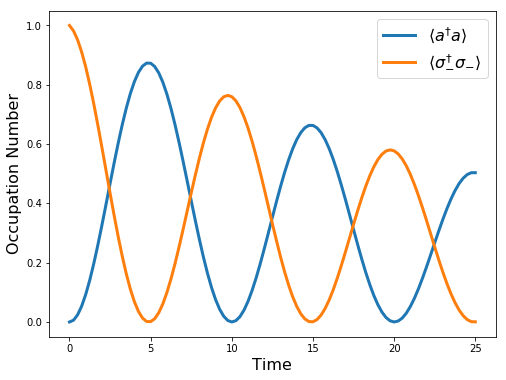

In [5]:
plt.figure(figsize=(8,6))
plt.plot(tlist,output.expect[0], lw=3)
plt.plot(tlist,output.expect[1], lw=3)
plt.legend(['$\langle a^{\dagger}a\\rangle$',
            '$\langle \sigma_{-}^{\dagger}\sigma_{-}\\rangle$'],
           loc=1,fontsize=16)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Occupation Number', fontsize=16);

## State of the cavity

Output states from master equation solver, and look at Wigner function of cavity.

In [6]:
output = qt.mesolve(H, psi0, tlist, c_ops, [])

In [11]:
t_idx = np.where([tlist == t for t in [0.0, 5, 15, 25]])[1]
cavity_rho_list = [output.states[kk].ptrace(0) for kk in t_idx]

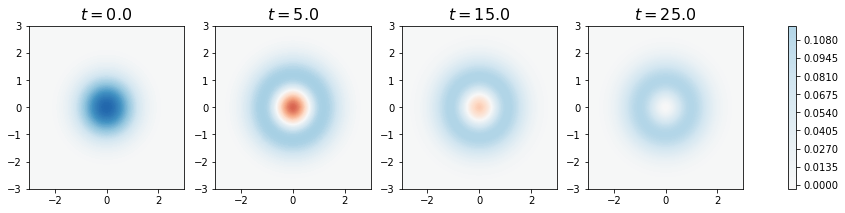

In [12]:
# loop over the list of density matrices

xvec = np.linspace(-3,3,200)

fig, axes = plt.subplots(1,len(cavity_rho_list), sharex=True, 
                         figsize=(4*len(cavity_rho_list),3))

for idx, rho in enumerate(cavity_rho_list):
    # calculate its wigner function
    W = qt.wigner(rho, xvec, xvec)
    # plot its wigner function
    cf = axes[idx].contourf(xvec, xvec, W, 100, vmin=-0.4, vmax=0.4, cmap='RdBu')
    axes[idx].set_title(r"$t = %.1f$" % tlist[t_idx][idx], fontsize=16)
cbar = fig.colorbar(cf, ax=axes.ravel().tolist())

## What does super operator look like

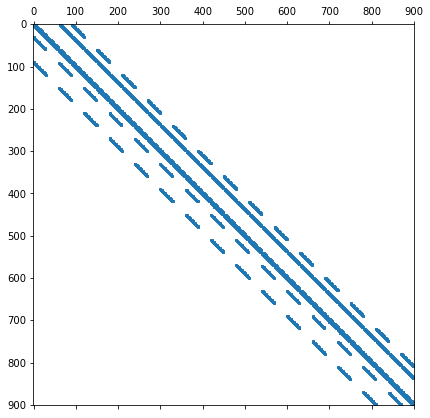

In [13]:
plt.figure(figsize=(7,7))
plt.spy(qt.liouvillian(H,c_ops).data,ms=2)

It is easy to see that the Liouvillian super operator is non-Hermitian.  This is to be expected as our evolution traces over the environment which, as we have seen, leads to mixed states independent of the purity of the initial state; something that cannot happen in unitary evolution:

$$
\mathrm{Tr}\left[\rho(t)^{2}\right] = \mathrm{Tr}\left[U(t)\rho(0)U^{\dagger}(t)U(t)\rho(0)U^{\dagger}(t)\right] = \mathrm{Tr}\left[\rho(0)^{2}\right]
$$